<a href="https://colab.research.google.com/github/ilinashah177/Coursework-Website/blob/main/Sentiment_Analysis_and_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install spacy
!pip install scattertext
!pip install tika
!pip install spacytextblob
!python -m spacy download en_core_web_sm

In [2]:
import spacy
import json
import pylab
from IPython.core.display import display, HTML
import nltk
from tika import parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacytextblob.spacytextblob import SpacyTextBlob

%matplotlib inline
pylab.rcParams['figure.figsize'] = (10., 8.)
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

In [3]:
import re
def process_urls(csv):
    try:
        df = pd.read_csv(csv)
    except:
        print(f"Error reading the file")
        return None

#Error handling
    if not all(col in df.columns for col in ['Country', 'URL']):
        print("Error: 'country' and 'url' columns are required.")
        return None

    processed_urls = set()
    results = []

    for index, row in df.iterrows():
        country = row['Country']
        url = row['URL']

        if url in processed_urls:
            continue

#Using TIKA parser
        try:
            raw = parser.from_file(url)
            text = raw['content']

#Data cleaning
            if text:
                text = " ".join(text.split())
                text = re.sub(r"[^a-zA-Z ]+", "", text)
                text = text.lower()

#Calculate polarity and subjectivity
            if text:
                doc = nlp(text)
                polarity = doc._.blob.polarity
                subjectivity = doc._.blob.subjectivity

#Classify sentiment based on polarity scores
                if polarity > 0.05 :
                    sentiment_score_classification = "Positive"
                elif polarity < -0.05:
                    sentiment_score_classification = "Negative"
                else:
                    sentiment_score_classification = "Neutral"

                results.append([country, url, polarity, subjectivity, sentiment_score_classification])
                processed_urls.add(url)

#Error handling
        except:
            print(f"Error processing URL")
            continue

    new_df = pd.DataFrame(results, columns=['country', 'url', 'polarity', 'subjectivity', 'sentiment_score_classification'])
    return new_df

In [4]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():

  processed_data = process_urls(fn)

processed_data

2025-01-26 22:03:29,397 [MainThread  ] [INFO ]  Retrieving https://pubmed.ncbi.nlm.nih.gov/39592827/ to /tmp/39592827.
INFO:tika.tika:Retrieving https://pubmed.ncbi.nlm.nih.gov/39592827/ to /tmp/39592827.


Saving NLP Sentiments 5.csv to NLP Sentiments 5.csv


2025-01-26 22:03:29,704 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar to /tmp/tika-server.jar.
INFO:tika.tika:Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar to /tmp/tika-server.jar.
2025-01-26 22:03:30,245 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar.md5 to /tmp/tika-server.jar.md5.
INFO:tika.tika:Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server-standard/2.6.0/tika-server-standard-2.6.0.jar.md5 to /tmp/tika-server.jar.md5.
2025-01-26 22:03:30,641 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...
2025-01-26 22:03:36,889 [MainThread  ] [INFO ]  Retrieving https://www.sciencedirect.com/science/article/pii/S0960148122003494 to /tmp/

Error processing URL


2025-01-26 22:03:37,417 [MainThread  ] [INFO ]  Retrieving https://sdpi.org/assets/lib/uploads/Environmental-implications-of-coal-based-energy-under-CPEC.pdf to /tmp/assets-lib-uploads-environmental-implications-of-coal-based-energy-under-cpec.pdf.
INFO:tika.tika:Retrieving https://sdpi.org/assets/lib/uploads/Environmental-implications-of-coal-based-energy-under-CPEC.pdf to /tmp/assets-lib-uploads-environmental-implications-of-coal-based-energy-under-cpec.pdf.


Error processing URL


2025-01-26 22:03:39,949 [MainThread  ] [INFO ]  Retrieving https://cscr.pk/explore/themes/energy-environment/cpec-promoting-green-and-sustainable-development/ to /tmp/explore-themes-energy-environment-cpec-promoting-green-and-sustainable-development.
INFO:tika.tika:Retrieving https://cscr.pk/explore/themes/energy-environment/cpec-promoting-green-and-sustainable-development/ to /tmp/explore-themes-energy-environment-cpec-promoting-green-and-sustainable-development.
2025-01-26 22:03:40,793 [MainThread  ] [INFO ]  Retrieving https://pmc.ncbi.nlm.nih.gov/articles/PMC11259830/ to /tmp/articles-pmc11259830.
INFO:tika.tika:Retrieving https://pmc.ncbi.nlm.nih.gov/articles/PMC11259830/ to /tmp/articles-pmc11259830.


Error processing URL


2025-01-26 22:03:41,291 [MainThread  ] [INFO ]  Retrieving https://sdpi.org/green-china-pakistan-economic-corridor-cpec-alliance/event_detail to /tmp/green-china-pakistan-economic-corridor-cpec-alliance-event_detail.
INFO:tika.tika:Retrieving https://sdpi.org/green-china-pakistan-economic-corridor-cpec-alliance/event_detail to /tmp/green-china-pakistan-economic-corridor-cpec-alliance-event_detail.


Error processing URL


2025-01-26 22:03:42,713 [MainThread  ] [INFO ]  Retrieving https://link.springer.com/article/10.1007/s11356-022-22813-3 to /tmp/article-10.1007-s11356-022-22813-3.
INFO:tika.tika:Retrieving https://link.springer.com/article/10.1007/s11356-022-22813-3 to /tmp/article-10.1007-s11356-022-22813-3.
2025-01-26 22:03:48,067 [MainThread  ] [INFO ]  Retrieving https://people.climate.columbia.edu/projects/view/232 to /tmp/projects-view-232.
INFO:tika.tika:Retrieving https://people.climate.columbia.edu/projects/view/232 to /tmp/projects-view-232.
2025-01-26 22:03:48,632 [MainThread  ] [INFO ]  Retrieving https://dialogue.earth/en/business/11750-why-don-t-cpec-projects-factor-in-the-climate-crisis/ to /tmp/en-business-11750-why-don-t-cpec-projects-factor-in-the-climate-crisis.
INFO:tika.tika:Retrieving https://dialogue.earth/en/business/11750-why-don-t-cpec-projects-factor-in-the-climate-crisis/ to /tmp/en-business-11750-why-don-t-cpec-projects-factor-in-the-climate-crisis.
2025-01-26 22:03:50,312

Error processing URL


2025-01-26 22:04:08,080 [MainThread  ] [INFO ]  Retrieving http://ajss.abasyn.edu.pk/admineditor/papers/V11I1-13.pdf to /tmp/admineditor-papers-v11i1-13.pdf.
INFO:tika.tika:Retrieving http://ajss.abasyn.edu.pk/admineditor/papers/V11I1-13.pdf to /tmp/admineditor-papers-v11i1-13.pdf.
2025-01-26 22:04:10,561 [MainThread  ] [INFO ]  Retrieving https://pureportal.strath.ac.uk/en/publications/china-pakistan-economic-corridor-cpec-tourism-demand-and-environm/fingerprints/ to /tmp/en-publications-china-pakistan-economic-corridor-cpec-tourism-demand-and-environm-fingerprints.
INFO:tika.tika:Retrieving https://pureportal.strath.ac.uk/en/publications/china-pakistan-economic-corridor-cpec-tourism-demand-and-environm/fingerprints/ to /tmp/en-publications-china-pakistan-economic-corridor-cpec-tourism-demand-and-environm-fingerprints.
2025-01-26 22:04:10,976 [MainThread  ] [INFO ]  Retrieving https://newlinesinstitute.org/strategic-competition/mapping-a-u-s-strategy-to-counter-chinas-cpec-clout/ to /

Error processing URL


2025-01-26 22:04:11,278 [MainThread  ] [INFO ]  Retrieving https://www.thenews.com.pk/magazine/money-matters/1232789-cpecs-road-to-renewables to /tmp/magazine-money-matters-1232789-cpecs-road-to-renewables.
INFO:tika.tika:Retrieving https://www.thenews.com.pk/magazine/money-matters/1232789-cpecs-road-to-renewables to /tmp/magazine-money-matters-1232789-cpecs-road-to-renewables.
2025-01-26 22:04:11,436 [MainThread  ] [INFO ]  Retrieving https://www.thehindu.com/news/international/china-refuses-to-further-expand-cooperation-with-pak-in-energy-water-climate-under-cpec/article67348727.ece to /tmp/news-international-china-refuses-to-further-expand-cooperation-with-pak-in-energy-water-climate-under-cpec-article67348727.ece.
INFO:tika.tika:Retrieving https://www.thehindu.com/news/international/china-refuses-to-further-expand-cooperation-with-pak-in-energy-water-climate-under-cpec/article67348727.ece to /tmp/news-international-china-refuses-to-further-expand-cooperation-with-pak-in-energy-wate

Error processing URL
Error processing URL


2025-01-26 22:04:11,573 [MainThread  ] [INFO ]  Retrieving https://issra.pk/pub/insight/2023/A-DECADE-OF-CPEC–AN-APPRAISAL/A-DECADE-OF-CPEC–AN-APPRAISAL.html to /tmp/pub-insight-2023-a-decade-of-cpec-an-appraisal-a-decade-of-cpec-an-appraisal.html.
INFO:tika.tika:Retrieving https://issra.pk/pub/insight/2023/A-DECADE-OF-CPEC–AN-APPRAISAL/A-DECADE-OF-CPEC–AN-APPRAISAL.html to /tmp/pub-insight-2023-a-decade-of-cpec-an-appraisal-a-decade-of-cpec-an-appraisal.html.
2025-01-26 22:04:11,578 [MainThread  ] [INFO ]  Retrieving https://www.gmfus.org/news/returning-shadows-china-pakistan-and-fate-cpec to /tmp/news-returning-shadows-china-pakistan-and-fate-cpec.
INFO:tika.tika:Retrieving https://www.gmfus.org/news/returning-shadows-china-pakistan-and-fate-cpec to /tmp/news-returning-shadows-china-pakistan-and-fate-cpec.
2025-01-26 22:04:11,744 [MainThread  ] [INFO ]  Retrieving https://www.dawn.com/news/1857807 to /tmp/news-1857807.
INFO:tika.tika:Retrieving https://www.dawn.com/news/1857807 to /t

Error processing URL
Error processing URL
Error processing URL


2025-01-26 22:04:13,415 [MainThread  ] [INFO ]  Retrieving https://eng.yidaiyilu.gov.cn/p/0JLDQFPD.html to /tmp/p-0jldqfpd.html.
INFO:tika.tika:Retrieving https://eng.yidaiyilu.gov.cn/p/0JLDQFPD.html to /tmp/p-0jldqfpd.html.
2025-01-26 22:04:18,466 [MainThread  ] [INFO ]  Retrieving https://www.worldscientific.com/doi/pdf/10.1142/S237774002150007X?srsltid=AfmBOorrzjQat0mHbvpzKzT25zkNRJYqJXEVZpIfh1g5pDBqzccZelwj to /tmp/doi-pdf-10.1142-s237774002150007x.
INFO:tika.tika:Retrieving https://www.worldscientific.com/doi/pdf/10.1142/S237774002150007X?srsltid=AfmBOorrzjQat0mHbvpzKzT25zkNRJYqJXEVZpIfh1g5pDBqzccZelwj to /tmp/doi-pdf-10.1142-s237774002150007x.
2025-01-26 22:04:18,649 [MainThread  ] [INFO ]  Retrieving https://www.pjoes.com/China-Pakistan-Economic-Corridor-nand-the-Impact-of-Coal-Based-Energy-Projects-non,112895,0,2.html to /tmp/china-pakistan-economic-corridor-nand-the-impact-of-coal-based-energy-projects-non-112895-0-2.html.
INFO:tika.tika:Retrieving https://www.pjoes.com/China-

Error processing URL


2025-01-26 22:04:20,431 [MainThread  ] [INFO ]  Retrieving https://www.lowyinstitute.org/the-interpreter/china-s-big-gamble-pakistan-10-year-scorecard-cpec to /tmp/the-interpreter-china-s-big-gamble-pakistan-10-year-scorecard-cpec.
INFO:tika.tika:Retrieving https://www.lowyinstitute.org/the-interpreter/china-s-big-gamble-pakistan-10-year-scorecard-cpec to /tmp/the-interpreter-china-s-big-gamble-pakistan-10-year-scorecard-cpec.
2025-01-26 22:04:21,839 [MainThread  ] [INFO ]  Retrieving https://vc.bridgew.edu/cgi/viewcontent.cgi?article=2132&context=jiws to /tmp/cgi-viewcontent.cgi.
INFO:tika.tika:Retrieving https://vc.bridgew.edu/cgi/viewcontent.cgi?article=2132&context=jiws to /tmp/cgi-viewcontent.cgi.
2025-01-26 22:04:23,993 [MainThread  ] [INFO ]  Retrieving  https://ieeexplore.ieee.org/document/8346410 to /tmp/document-8346410.
INFO:tika.tika:Retrieving  https://ieeexplore.ieee.org/document/8346410 to /tmp/document-8346410.
2025-01-26 22:04:24,112 [MainThread  ] [INFO ]  Retrieving 

Error processing URL


2025-01-26 22:04:25,302 [MainThread  ] [INFO ]  Retrieving https://english.news.cn/20240822/b469184d934c4c0aa15298d50eb7a485/c.html to /tmp/20240822-b469184d934c4c0aa15298d50eb7a485-c.html.
INFO:tika.tika:Retrieving https://english.news.cn/20240822/b469184d934c4c0aa15298d50eb7a485/c.html to /tmp/20240822-b469184d934c4c0aa15298d50eb7a485-c.html.
2025-01-26 22:04:26,958 [MainThread  ] [INFO ]  Retrieving https://www.journal.multitechpublisher.com/index.php/ijla/article/view/2472/2566 to /tmp/index.php-ijla-article-view-2472-2566.
INFO:tika.tika:Retrieving https://www.journal.multitechpublisher.com/index.php/ijla/article/view/2472/2566 to /tmp/index.php-ijla-article-view-2472-2566.
2025-01-26 22:04:27,951 [MainThread  ] [INFO ]  Retrieving https://www.mei.edu/publications/imf-cpec-and-pakistan-will-chinese-save-islamabad-yet-again to /tmp/publications-imf-cpec-and-pakistan-will-chinese-save-islamabad-yet-again.
INFO:tika.tika:Retrieving https://www.mei.edu/publications/imf-cpec-and-pakist

Error processing URL
Error processing URL


2025-01-26 22:04:29,973 [MainThread  ] [INFO ]  Retrieving https://www.medwinpublishers.com/article-description.php?artId=12274 to /tmp/article-description.php.
INFO:tika.tika:Retrieving https://www.medwinpublishers.com/article-description.php?artId=12274 to /tmp/article-description.php.
2025-01-26 22:04:30,403 [MainThread  ] [INFO ]  Retrieving https://www.ejosdr.com/download/environmental-impact-assessment-eia-of-cpec-road-project-by-following-eia-index-approach-for-13107.pdf to /tmp/download-environmental-impact-assessment-eia-of-cpec-road-project-by-following-eia-index-approach-for-13107.pdf.
INFO:tika.tika:Retrieving https://www.ejosdr.com/download/environmental-impact-assessment-eia-of-cpec-road-project-by-following-eia-index-approach-for-13107.pdf to /tmp/download-environmental-impact-assessment-eia-of-cpec-road-project-by-following-eia-index-approach-for-13107.pdf.
2025-01-26 22:04:36,273 [MainThread  ] [INFO ]  Retrieving https://www.chinadailyhk.com/hk/article/595324 to /tmp/

Error processing URL
Error processing URL


2025-01-26 22:04:53,007 [MainThread  ] [INFO ]  Retrieving https://www.cadtm.org/Pakistan-CPEC-A-game-changer-or-another-East-India-Company to /tmp/pakistan-cpec-a-game-changer-or-another-east-india-company.
INFO:tika.tika:Retrieving https://www.cadtm.org/Pakistan-CPEC-A-game-changer-or-another-East-India-Company to /tmp/pakistan-cpec-a-game-changer-or-another-east-india-company.
2025-01-26 22:04:55,290 [MainThread  ] [INFO ]  Retrieving https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3928027 to /tmp/sol3-papers.cfm.
INFO:tika.tika:Retrieving https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3928027 to /tmp/sol3-papers.cfm.
2025-01-26 22:04:55,513 [MainThread  ] [INFO ]  Retrieving https://www.cpicglobal.com/urbanizing-infrastructure-pakistan-china-collaboration-under-cpec/ to /tmp/urbanizing-infrastructure-pakistan-china-collaboration-under-cpec.
INFO:tika.tika:Retrieving https://www.cpicglobal.com/urbanizing-infrastructure-pakistan-china-collaboration-under-cpec/ to /tmp/urbani

Error processing URL
Error processing URL


2025-01-26 22:04:57,068 [MainThread  ] [INFO ]  Retrieving https://www.jstor.org/stable/resrep34174.4?seq=1 to /tmp/stable-resrep34174.4.
INFO:tika.tika:Retrieving https://www.jstor.org/stable/resrep34174.4?seq=1 to /tmp/stable-resrep34174.4.
2025-01-26 22:04:57,333 [MainThread  ] [INFO ]  Retrieving https://www.cell.com/heliyon/fulltext/S2405-8440(24)09386-1 to /tmp/heliyon-fulltext-s2405-8440-24-09386-1.
INFO:tika.tika:Retrieving https://www.cell.com/heliyon/fulltext/S2405-8440(24)09386-1 to /tmp/heliyon-fulltext-s2405-8440-24-09386-1.


Error processing URL


2025-01-26 22:04:57,568 [MainThread  ] [INFO ]  Retrieving https://www.e-ir.info/2022/03/10/cpec-an-assessment-of-its-socio-economic-impact-on-pakistan/ to /tmp/2022-03-10-cpec-an-assessment-of-its-socio-economic-impact-on-pakistan.
INFO:tika.tika:Retrieving https://www.e-ir.info/2022/03/10/cpec-an-assessment-of-its-socio-economic-impact-on-pakistan/ to /tmp/2022-03-10-cpec-an-assessment-of-its-socio-economic-impact-on-pakistan.


Error processing URL


2025-01-26 22:04:59,591 [MainThread  ] [INFO ]  Retrieving https://pandapawdragonclaw.blog/2018/12/01/unpacking-chinese-financing-of-pakistans-dream-power-plant/ to /tmp/2018-12-01-unpacking-chinese-financing-of-pakistans-dream-power-plant.
INFO:tika.tika:Retrieving https://pandapawdragonclaw.blog/2018/12/01/unpacking-chinese-financing-of-pakistans-dream-power-plant/ to /tmp/2018-12-01-unpacking-chinese-financing-of-pakistans-dream-power-plant.
2025-01-26 22:05:00,956 [MainThread  ] [INFO ]  Retrieving https://www.finance.gov.pk/survey/chapters_17/Annex_III_CPEC.pdf to /tmp/survey-chapters_17-annex_iii_cpec.pdf.
INFO:tika.tika:Retrieving https://www.finance.gov.pk/survey/chapters_17/Annex_III_CPEC.pdf to /tmp/survey-chapters_17-annex_iii_cpec.pdf.
2025-01-26 22:05:03,731 [MainThread  ] [INFO ]  Retrieving https://ui.adsabs.harvard.edu/abs/2023WCE....4000570U/abstract to /tmp/abs-2023wce....4000570u-abstract.
INFO:tika.tika:Retrieving https://ui.adsabs.harvard.edu/abs/2023WCE....4000570

Error processing URL


2025-01-26 22:05:04,804 [MainThread  ] [INFO ]  Retrieving https://pogeepakistan.com/news/cpec-driving-regional-and-international-growth-and-development/ to /tmp/news-cpec-driving-regional-and-international-growth-and-development.
INFO:tika.tika:Retrieving https://pogeepakistan.com/news/cpec-driving-regional-and-international-growth-and-development/ to /tmp/news-cpec-driving-regional-and-international-growth-and-development.
2025-01-26 22:05:06,934 [MainThread  ] [INFO ]  Retrieving https://www.orfonline.org/expert-speak/pakistan-why-has-china-halted-cpec-projects to /tmp/expert-speak-pakistan-why-has-china-halted-cpec-projects.
INFO:tika.tika:Retrieving https://www.orfonline.org/expert-speak/pakistan-why-has-china-halted-cpec-projects to /tmp/expert-speak-pakistan-why-has-china-halted-cpec-projects.
2025-01-26 22:05:07,053 [MainThread  ] [INFO ]  Retrieving https://www.globaltimes.cn/page/202302/1284986.shtml to /tmp/page-202302-1284986.shtml.
INFO:tika.tika:Retrieving https://www.glo

Error processing URL


2025-01-26 22:05:07,658 [MainThread  ] [INFO ]  Retrieving https://asiatimes.com/2017/03/cpec-game-changer-might-change-nothing/ to /tmp/2017-03-cpec-game-changer-might-change-nothing.
INFO:tika.tika:Retrieving https://asiatimes.com/2017/03/cpec-game-changer-might-change-nothing/ to /tmp/2017-03-cpec-game-changer-might-change-nothing.
2025-01-26 22:05:11,437 [MainThread  ] [INFO ]  Retrieving https://muse.jhu.edu/article/837036 to /tmp/article-837036.
INFO:tika.tika:Retrieving https://muse.jhu.edu/article/837036 to /tmp/article-837036.
2025-01-26 22:05:11,960 [MainThread  ] [INFO ]  Retrieving https://english.www.gov.cn/news/internationalexchanges/202112/09/content_WS61b1b9e6c6d09c94e48a2022.html to /tmp/news-internationalexchanges-202112-09-content_ws61b1b9e6c6d09c94e48a2022.html.
INFO:tika.tika:Retrieving https://english.www.gov.cn/news/internationalexchanges/202112/09/content_WS61b1b9e6c6d09c94e48a2022.html to /tmp/news-internationalexchanges-202112-09-content_ws61b1b9e6c6d09c94e48a

Error processing URL


2025-01-26 22:05:13,582 [MainThread  ] [INFO ]  Retrieving https://ouci.dntb.gov.ua/en/works/lxK0YB84/ to /tmp/en-works-lxk0yb84.
INFO:tika.tika:Retrieving https://ouci.dntb.gov.ua/en/works/lxK0YB84/ to /tmp/en-works-lxk0yb84.
2025-01-26 22:05:15,854 [MainThread  ] [INFO ]  Retrieving https://uclg-aspac.org/brlc/2021/09/24/green-economic-corridor-contributes-to-pakistans-sustainable-development/ to /tmp/brlc-2021-09-24-green-economic-corridor-contributes-to-pakistans-sustainable-development.
INFO:tika.tika:Retrieving https://uclg-aspac.org/brlc/2021/09/24/green-economic-corridor-contributes-to-pakistans-sustainable-development/ to /tmp/brlc-2021-09-24-green-economic-corridor-contributes-to-pakistans-sustainable-development.
2025-01-26 22:05:17,553 [MainThread  ] [INFO ]  Retrieving https://www.proquest.com/docview/2356831322?pq-origsite=gscholar&fromopenview=true&sourcetype=Scholarly%20Journals to /tmp/docview-2356831322.
INFO:tika.tika:Retrieving https://www.proquest.com/docview/23568

Error processing URL


2025-01-26 22:05:20,509 [MainThread  ] [INFO ]  Retrieving https://discovery.researcher.life/article/risk-assessment-of-sustainable-renewable-energy-resources-on-cpec-route/446f8e9f0dd53398afe2c430d84bba19 to /tmp/article-risk-assessment-of-sustainable-renewable-energy-resources-on-cpec-route-446f8e9f0dd53398afe2c430d84bba19.
INFO:tika.tika:Retrieving https://discovery.researcher.life/article/risk-assessment-of-sustainable-renewable-energy-resources-on-cpec-route/446f8e9f0dd53398afe2c430d84bba19 to /tmp/article-risk-assessment-of-sustainable-renewable-energy-resources-on-cpec-route-446f8e9f0dd53398afe2c430d84bba19.
2025-01-26 22:05:24,297 [MainThread  ] [INFO ]  Retrieving https://research.brighton.ac.uk/en/publications/integration-of-green-supply-chain-management-practices-in-constru to /tmp/en-publications-integration-of-green-supply-chain-management-practices-in-constru.
INFO:tika.tika:Retrieving https://research.brighton.ac.uk/en/publications/integration-of-green-supply-chain-manag

Error processing URL


2025-01-26 22:05:26,169 [MainThread  ] [INFO ]  Retrieving https://english.news.cn/20230406/ce8a47f71f9244e09669f7c7449c7ef7/c.html to /tmp/20230406-ce8a47f71f9244e09669f7c7449c7ef7-c.html.
INFO:tika.tika:Retrieving https://english.news.cn/20230406/ce8a47f71f9244e09669f7c7449c7ef7/c.html to /tmp/20230406-ce8a47f71f9244e09669f7c7449c7ef7-c.html.
2025-01-26 22:05:27,378 [MainThread  ] [INFO ]  Retrieving https://www.degruyter.com/document/doi/10.1515/reveh-2020-0111/html?lang=en&srsltid=AfmBOooMACMcsIYFJil8wHS2I6diH5bn-ylJZ2p8xCs6byrZeQftHTrZ to /tmp/document-doi-10.1515-reveh-2020-0111-html.
INFO:tika.tika:Retrieving https://www.degruyter.com/document/doi/10.1515/reveh-2020-0111/html?lang=en&srsltid=AfmBOooMACMcsIYFJil8wHS2I6diH5bn-ylJZ2p8xCs6byrZeQftHTrZ to /tmp/document-doi-10.1515-reveh-2020-0111-html.
2025-01-26 22:05:28,550 [MainThread  ] [INFO ]  Retrieving https://www.world-energy.org/article/29273.html to /tmp/article-29273.html.
INFO:tika.tika:Retrieving https://www.world-energ

Error processing URL


2025-01-26 22:05:30,285 [MainThread  ] [INFO ]  Retrieving https://gunnersshot.com/2019/12/08/coal-firing-cpec-colonisation-of-pakistan-enrichment-of-china/ to /tmp/2019-12-08-coal-firing-cpec-colonisation-of-pakistan-enrichment-of-china.
INFO:tika.tika:Retrieving https://gunnersshot.com/2019/12/08/coal-firing-cpec-colonisation-of-pakistan-enrichment-of-china/ to /tmp/2019-12-08-coal-firing-cpec-colonisation-of-pakistan-enrichment-of-china.
2025-01-26 22:05:31,089 [MainThread  ] [INFO ]  Retrieving https://cscr.pk/explore/themes/trade-economics/cpec-through-the-lens-of-pakistans-foreign-policy/ to /tmp/explore-themes-trade-economics-cpec-through-the-lens-of-pakistans-foreign-policy.
INFO:tika.tika:Retrieving https://cscr.pk/explore/themes/trade-economics/cpec-through-the-lens-of-pakistans-foreign-policy/ to /tmp/explore-themes-trade-economics-cpec-through-the-lens-of-pakistans-foreign-policy.
2025-01-26 22:05:31,803 [MainThread  ] [INFO ]  Retrieving https://journals.umt.edu.pk/index.p

Error processing URL


2025-01-26 22:05:32,103 [MainThread  ] [INFO ]  Retrieving https://cscc.sas.upenn.edu/events/2020/02/25/china-pakistan-economic-corridor-power-projects-insights-environmental-and-debt to /tmp/events-2020-02-25-china-pakistan-economic-corridor-power-projects-insights-environmental-and-debt.
INFO:tika.tika:Retrieving https://cscc.sas.upenn.edu/events/2020/02/25/china-pakistan-economic-corridor-power-projects-insights-environmental-and-debt to /tmp/events-2020-02-25-china-pakistan-economic-corridor-power-projects-insights-environmental-and-debt.


Error processing URL


2025-01-26 22:05:32,567 [MainThread  ] [INFO ]  Retrieving https://www.csis.org/analysis/china-pakistan-economic-corridor-five to /tmp/analysis-china-pakistan-economic-corridor-five.
INFO:tika.tika:Retrieving https://www.csis.org/analysis/china-pakistan-economic-corridor-five to /tmp/analysis-china-pakistan-economic-corridor-five.
2025-01-26 22:05:33,733 [MainThread  ] [INFO ]  Retrieving https://science.thewire.in/external-affairs/south-asia/cpec-china-pakistan-military-environment-coal/ to /tmp/external-affairs-south-asia-cpec-china-pakistan-military-environment-coal.
INFO:tika.tika:Retrieving https://science.thewire.in/external-affairs/south-asia/cpec-china-pakistan-military-environment-coal/ to /tmp/external-affairs-south-asia-cpec-china-pakistan-military-environment-coal.
2025-01-26 22:05:35,720 [MainThread  ] [INFO ]  Retrieving https://www.jstor.org/stable/44986508?seq=1 to /tmp/stable-44986508.
INFO:tika.tika:Retrieving https://www.jstor.org/stable/44986508?seq=1 to /tmp/stable

Error processing URL


2025-01-26 22:05:37,422 [MainThread  ] [INFO ]  Retrieving https://www.cell.com/heliyon/fulltext/S2405-8440(24)09386-1 to /tmp/heliyon-fulltext-s2405-8440-24-09386-1.
INFO:tika.tika:Retrieving https://www.cell.com/heliyon/fulltext/S2405-8440(24)09386-1 to /tmp/heliyon-fulltext-s2405-8440-24-09386-1.
2025-01-26 22:05:37,635 [MainThread  ] [INFO ]  Retrieving https://www.eco-business.com/zh-hans/opinion/why-dont-cpec-projects-factor-in-the-climate-crisis/ to /tmp/zh-hans-opinion-why-dont-cpec-projects-factor-in-the-climate-crisis.
INFO:tika.tika:Retrieving https://www.eco-business.com/zh-hans/opinion/why-dont-cpec-projects-factor-in-the-climate-crisis/ to /tmp/zh-hans-opinion-why-dont-cpec-projects-factor-in-the-climate-crisis.


Error processing URL


2025-01-26 22:05:39,238 [MainThread  ] [INFO ]  Retrieving https://www.ingentaconnect.com/content/mcb/ijdi/2021/00000021/00000001/art00008 to /tmp/content-mcb-ijdi-2021-00000021-00000001-art00008.
INFO:tika.tika:Retrieving https://www.ingentaconnect.com/content/mcb/ijdi/2021/00000021/00000001/art00008 to /tmp/content-mcb-ijdi-2021-00000021-00000001-art00008.
2025-01-26 22:05:39,415 [MainThread  ] [INFO ]  Retrieving https://www.iiss.org/online-analysis/online-analysis/2019/09/sasia-pakistan-protects-chinese-investments/ to /tmp/online-analysis-online-analysis-2019-09-sasia-pakistan-protects-chinese-investments.
INFO:tika.tika:Retrieving https://www.iiss.org/online-analysis/online-analysis/2019/09/sasia-pakistan-protects-chinese-investments/ to /tmp/online-analysis-online-analysis-2019-09-sasia-pakistan-protects-chinese-investments.


Error processing URL


2025-01-26 22:05:39,622 [MainThread  ] [INFO ]  Retrieving https://global.chinadaily.com.cn/a/202403/04/WS65e57fc3a31082fc043ba7f2.html to /tmp/a-202403-04-ws65e57fc3a31082fc043ba7f2.html.
INFO:tika.tika:Retrieving https://global.chinadaily.com.cn/a/202403/04/WS65e57fc3a31082fc043ba7f2.html to /tmp/a-202403-04-ws65e57fc3a31082fc043ba7f2.html.


Error processing URL


2025-01-26 22:05:40,360 [MainThread  ] [INFO ]  Retrieving https://iucn.org/news/pakistan/201902/chinese-delegation-studying-belt-and-road-initiative-calls-environmental-safeguards-along-cpec to /tmp/news-pakistan-201902-chinese-delegation-studying-belt-and-road-initiative-calls-environmental-safeguards-along-cpec.
INFO:tika.tika:Retrieving https://iucn.org/news/pakistan/201902/chinese-delegation-studying-belt-and-road-initiative-calls-environmental-safeguards-along-cpec to /tmp/news-pakistan-201902-chinese-delegation-studying-belt-and-road-initiative-calls-environmental-safeguards-along-cpec.
2025-01-26 22:05:40,502 [MainThread  ] [INFO ]  Retrieving https://www.mdpi.com/2071-1050/15/7/5870 to /tmp/2071-1050-15-7-5870.
INFO:tika.tika:Retrieving https://www.mdpi.com/2071-1050/15/7/5870 to /tmp/2071-1050-15-7-5870.
2025-01-26 22:05:40,626 [MainThread  ] [INFO ]  Retrieving https://www.cpicglobal.com/how-cpec-is-contributing-to-green-and-sustainable-development/ to /tmp/how-cpec-is-contr

Error processing URL
Error processing URL


2025-01-26 22:05:40,738 [MainThread  ] [INFO ]  Retrieving https://cscr.pk/explore/themes/energy-environment/dirty-energy-in-new-pakistan/ to /tmp/explore-themes-energy-environment-dirty-energy-in-new-pakistan.
INFO:tika.tika:Retrieving https://cscr.pk/explore/themes/energy-environment/dirty-energy-in-new-pakistan/ to /tmp/explore-themes-energy-environment-dirty-energy-in-new-pakistan.


Error processing URL


2025-01-26 22:05:41,356 [MainThread  ] [INFO ]  Retrieving https://www.eurasiareview.com/29032018-cpec-an-environment-friendly-project-oped/ to /tmp/29032018-cpec-an-environment-friendly-project-oped.
INFO:tika.tika:Retrieving https://www.eurasiareview.com/29032018-cpec-an-environment-friendly-project-oped/ to /tmp/29032018-cpec-an-environment-friendly-project-oped.
2025-01-26 22:05:41,483 [MainThread  ] [INFO ]  Retrieving https://profit.pakistantoday.com.pk/2025/01/20/green-sez-development-under-cpec-opportunity-for-pakistan-to-raise-climate-competitive-industry-experts/ to /tmp/2025-01-20-green-sez-development-under-cpec-opportunity-for-pakistan-to-raise-climate-competitive-industry-experts.
INFO:tika.tika:Retrieving https://profit.pakistantoday.com.pk/2025/01/20/green-sez-development-under-cpec-opportunity-for-pakistan-to-raise-climate-competitive-industry-experts/ to /tmp/2025-01-20-green-sez-development-under-cpec-opportunity-for-pakistan-to-raise-climate-competitive-industry-exp

Error processing URL
Error processing URL


2025-01-26 22:05:41,594 [MainThread  ] [INFO ]  Retrieving https://ieeexplore.ieee.org/document/9417226 to /tmp/document-9417226.
INFO:tika.tika:Retrieving https://ieeexplore.ieee.org/document/9417226 to /tmp/document-9417226.
2025-01-26 22:05:41,681 [MainThread  ] [INFO ]  Retrieving https://cpecwire.com/analysis/china-pakistan-economic-corridor-what-is-cpec-faq/ to /tmp/analysis-china-pakistan-economic-corridor-what-is-cpec-faq.
INFO:tika.tika:Retrieving https://cpecwire.com/analysis/china-pakistan-economic-corridor-what-is-cpec-faq/ to /tmp/analysis-china-pakistan-economic-corridor-what-is-cpec-faq.


Error processing URL
Error processing URL


2025-01-26 22:05:41,799 [MainThread  ] [INFO ]  Retrieving https://carbs.superior.edu.pk/policy-lab/policy-paths-of-cpec-a-threat-to-environmental-degradation-in-pakistan/ to /tmp/policy-lab-policy-paths-of-cpec-a-threat-to-environmental-degradation-in-pakistan.
INFO:tika.tika:Retrieving https://carbs.superior.edu.pk/policy-lab/policy-paths-of-cpec-a-threat-to-environmental-degradation-in-pakistan/ to /tmp/policy-lab-policy-paths-of-cpec-a-threat-to-environmental-degradation-in-pakistan.


Error processing URL


2025-01-26 22:05:45,210 [MainThread  ] [INFO ]  Retrieving https://www.dawn.com/news/1780109 to /tmp/news-1780109.
INFO:tika.tika:Retrieving https://www.dawn.com/news/1780109 to /tmp/news-1780109.
2025-01-26 22:05:46,488 [MainThread  ] [INFO ]  Retrieving https://www.cfr.org/expert-brief/behind-chinas-gambit-pakistan to /tmp/expert-brief-behind-chinas-gambit-pakistan.
INFO:tika.tika:Retrieving https://www.cfr.org/expert-brief/behind-chinas-gambit-pakistan to /tmp/expert-brief-behind-chinas-gambit-pakistan.
2025-01-26 22:05:46,619 [MainThread  ] [INFO ]  Retrieving https://www.wilsoncenter.org/event/webcast-its-not-easy-being-green-obstacles-clean-energy-china-pakistan-economic-corridor to /tmp/event-webcast-its-not-easy-being-green-obstacles-clean-energy-china-pakistan-economic-corridor.
INFO:tika.tika:Retrieving https://www.wilsoncenter.org/event/webcast-its-not-easy-being-green-obstacles-clean-energy-china-pakistan-economic-corridor to /tmp/event-webcast-its-not-easy-being-green-obst

Error processing URL


2025-01-26 22:05:47,615 [MainThread  ] [INFO ]  Retrieving https://www.degruyter.com/document/doi/10.1515/reveh-2020-0111/html?lang=en&srsltid=AfmBOooma-edT6uAXqIG1t6UlpsNyIOrvoTULFIwClRpDiYdZxQNwtkq to /tmp/document-doi-10.1515-reveh-2020-0111-html.
INFO:tika.tika:Retrieving https://www.degruyter.com/document/doi/10.1515/reveh-2020-0111/html?lang=en&srsltid=AfmBOooma-edT6uAXqIG1t6UlpsNyIOrvoTULFIwClRpDiYdZxQNwtkq to /tmp/document-doi-10.1515-reveh-2020-0111-html.
2025-01-26 22:05:49,467 [MainThread  ] [INFO ]  Retrieving https://www.weforum.org/stories/2018/07/opportunities-and-risks-the-china-pakistan-economic-corridor/ to /tmp/stories-2018-07-opportunities-and-risks-the-china-pakistan-economic-corridor.
INFO:tika.tika:Retrieving https://www.weforum.org/stories/2018/07/opportunities-and-risks-the-china-pakistan-economic-corridor/ to /tmp/stories-2018-07-opportunities-and-risks-the-china-pakistan-economic-corridor.
2025-01-26 22:05:49,819 [MainThread  ] [INFO ]  Retrieving https://www

Error processing URL


2025-01-26 22:05:50,328 [MainThread  ] [INFO ]  Retrieving https://www.newsecuritybeat.org/2022/02/reducing-environmental-social-costs-chinese-investments-pakistan/ to /tmp/2022-02-reducing-environmental-social-costs-chinese-investments-pakistan.
INFO:tika.tika:Retrieving https://www.newsecuritybeat.org/2022/02/reducing-environmental-social-costs-chinese-investments-pakistan/ to /tmp/2022-02-reducing-environmental-social-costs-chinese-investments-pakistan.
2025-01-26 22:05:52,021 [MainThread  ] [INFO ]  Retrieving https://tribune.com.pk/story/1447859/cpec-environment-good-bad-ugly to /tmp/story-1447859-cpec-environment-good-bad-ugly.
INFO:tika.tika:Retrieving https://tribune.com.pk/story/1447859/cpec-environment-good-bad-ugly to /tmp/story-1447859-cpec-environment-good-bad-ugly.
2025-01-26 22:05:52,583 [MainThread  ] [INFO ]  Retrieving https://www.voanews.com/a/china-calls-pakistan-cpec-fastest-and-most-effective-of-bri-projects/3951874.html to /tmp/a-china-calls-pakistan-cpec-fastest

Error processing URL


2025-01-26 22:06:02,819 [MainThread  ] [INFO ]  Retrieving https://pubs.aip.org/aip/jrse/article-abstract/10/6/065905/281336/Analysis-of-power-plants-in-China-Pakistan?redirectedFrom=fulltext to /tmp/aip-jrse-article-abstract-10-6-065905-281336-analysis-of-power-plants-in-china-pakistan.
INFO:tika.tika:Retrieving https://pubs.aip.org/aip/jrse/article-abstract/10/6/065905/281336/Analysis-of-power-plants-in-China-Pakistan?redirectedFrom=fulltext to /tmp/aip-jrse-article-abstract-10-6-065905-281336-analysis-of-power-plants-in-china-pakistan.
2025-01-26 22:06:02,925 [MainThread  ] [INFO ]  Retrieving https://www.reuters.com/article/world/pakistan-ramps-up-coal-power-with-chinese-backed-plants-idUSKBN17Z018/ to /tmp/article-world-pakistan-ramps-up-coal-power-with-chinese-backed-plants-iduskbn17z018.
INFO:tika.tika:Retrieving https://www.reuters.com/article/world/pakistan-ramps-up-coal-power-with-chinese-backed-plants-idUSKBN17Z018/ to /tmp/article-world-pakistan-ramps-up-coal-power-with-chi

Error processing URL
Error processing URL


2025-01-26 22:06:03,412 [MainThread  ] [INFO ]  Retrieving https://bulletin.ids.ac.uk/index.php/idsbo/article/view/3066/3047 to /tmp/index.php-idsbo-article-view-3066-3047.
INFO:tika.tika:Retrieving https://bulletin.ids.ac.uk/index.php/idsbo/article/view/3066/3047 to /tmp/index.php-idsbo-article-view-3066-3047.


Error processing URL


2025-01-26 22:06:03,922 [MainThread  ] [INFO ]  Retrieving https://www.cfr.org/backgrounder/chinas-massive-belt-and-road-initiative to /tmp/backgrounder-chinas-massive-belt-and-road-initiative.
INFO:tika.tika:Retrieving https://www.cfr.org/backgrounder/chinas-massive-belt-and-road-initiative to /tmp/backgrounder-chinas-massive-belt-and-road-initiative.
2025-01-26 22:06:04,022 [MainThread  ] [INFO ]  Retrieving https://ieefa.org/resources/pakistans-power-future-renewable-energy-provides-more-diverse-secure-and-cost-effective to /tmp/resources-pakistans-power-future-renewable-energy-provides-more-diverse-secure-and-cost-effective.
INFO:tika.tika:Retrieving https://ieefa.org/resources/pakistans-power-future-renewable-energy-provides-more-diverse-secure-and-cost-effective to /tmp/resources-pakistans-power-future-renewable-energy-provides-more-diverse-secure-and-cost-effective.


Error processing URL
Error processing URL


2025-01-26 22:06:04,161 [MainThread  ] [INFO ]  Retrieving https://www.bu.edu/pardeeschool/2017/12/01/najam-in-eurasia-reviwq-on-cpec-transparency/ to /tmp/pardeeschool-2017-12-01-najam-in-eurasia-reviwq-on-cpec-transparency.
INFO:tika.tika:Retrieving https://www.bu.edu/pardeeschool/2017/12/01/najam-in-eurasia-reviwq-on-cpec-transparency/ to /tmp/pardeeschool-2017-12-01-najam-in-eurasia-reviwq-on-cpec-transparency.
2025-01-26 22:06:04,323 [MainThread  ] [INFO ]  Retrieving https://www.nation.com.pk/21-Jan-2025/experts-call-for-learning-from-china-s-experience-in-developing-green-sezs-under-cpec to /tmp/21-jan-2025-experts-call-for-learning-from-china-s-experience-in-developing-green-sezs-under-cpec.
INFO:tika.tika:Retrieving https://www.nation.com.pk/21-Jan-2025/experts-call-for-learning-from-china-s-experience-in-developing-green-sezs-under-cpec to /tmp/21-jan-2025-experts-call-for-learning-from-china-s-experience-in-developing-green-sezs-under-cpec.


Error processing URL


2025-01-26 22:06:05,931 [MainThread  ] [INFO ]  Retrieving https://www.arabnews.com/node/2586996/pakistan to /tmp/node-2586996-pakistan.
INFO:tika.tika:Retrieving https://www.arabnews.com/node/2586996/pakistan to /tmp/node-2586996-pakistan.
2025-01-26 22:06:06,055 [MainThread  ] [INFO ]  Retrieving https://unpo.org/gilgit-baltistan-cpec-likely-to-worsen-environmental-degradation-in-the-region/ to /tmp/gilgit-baltistan-cpec-likely-to-worsen-environmental-degradation-in-the-region.
INFO:tika.tika:Retrieving https://unpo.org/gilgit-baltistan-cpec-likely-to-worsen-environmental-degradation-in-the-region/ to /tmp/gilgit-baltistan-cpec-likely-to-worsen-environmental-degradation-in-the-region.
2025-01-26 22:06:06,197 [MainThread  ] [INFO ]  Retrieving https://www.plenglish.com/news/2025/01/22/experts-call-for-developing-sezs-under-china-pakistan-cooperation/ to /tmp/news-2025-01-22-experts-call-for-developing-sezs-under-china-pakistan-cooperation.
INFO:tika.tika:Retrieving https://www.plengli

Error processing URL
Error processing URL


2025-01-26 22:06:08,373 [MainThread  ] [INFO ]  Retrieving http://en.people.cn/n3/2025/0122/c90000-20268972.html to /tmp/n3-2025-0122-c90000-20268972.html.
INFO:tika.tika:Retrieving http://en.people.cn/n3/2025/0122/c90000-20268972.html to /tmp/n3-2025-0122-c90000-20268972.html.
2025-01-26 22:06:09,420 [MainThread  ] [INFO ]  Retrieving https://asiatimes.com/2017/06/china-cant-lead-paris-accord-big-coal-cpec/ to /tmp/2017-06-china-cant-lead-paris-accord-big-coal-cpec.
INFO:tika.tika:Retrieving https://asiatimes.com/2017/06/china-cant-lead-paris-accord-big-coal-cpec/ to /tmp/2017-06-china-cant-lead-paris-accord-big-coal-cpec.
2025-01-26 22:06:12,977 [MainThread  ] [INFO ]  Retrieving https://oilprice.com/Energy/Energy-General/Is-Pakistans-Energy-Sector-a-Ticking-Time-Bomb.html to /tmp/energy-energy-general-is-pakistans-energy-sector-a-ticking-time-bomb.html.
INFO:tika.tika:Retrieving https://oilprice.com/Energy/Energy-General/Is-Pakistans-Energy-Sector-a-Ticking-Time-Bomb.html to /tmp/en

Error processing URL


2025-01-26 22:06:15,282 [MainThread  ] [INFO ]  Retrieving https://www.radio.gov.pk/22-01-2025/achieving-sustainable-development-pakistans-top-priority-aurangzeb to /tmp/22-01-2025-achieving-sustainable-development-pakistans-top-priority-aurangzeb.
INFO:tika.tika:Retrieving https://www.radio.gov.pk/22-01-2025/achieving-sustainable-development-pakistans-top-priority-aurangzeb to /tmp/22-01-2025-achieving-sustainable-development-pakistans-top-priority-aurangzeb.
2025-01-26 22:06:15,404 [MainThread  ] [INFO ]  Retrieving https://thepakistantimes.com.pk/tag/and-mutual-growth-he-acknowledged-the-transformative-impact-of-cpecs-first-phase/ to /tmp/tag-and-mutual-growth-he-acknowledged-the-transformative-impact-of-cpecs-first-phase.
INFO:tika.tika:Retrieving https://thepakistantimes.com.pk/tag/and-mutual-growth-he-acknowledged-the-transformative-impact-of-cpecs-first-phase/ to /tmp/tag-and-mutual-growth-he-acknowledged-the-transformative-impact-of-cpecs-first-phase.


Error processing URL


2025-01-26 22:06:17,278 [MainThread  ] [INFO ]  Retrieving https://tnnenglish.com/coal-a-double-edged-sword-for-energy-and-the-environment to /tmp/coal-a-double-edged-sword-for-energy-and-the-environment.
INFO:tika.tika:Retrieving https://tnnenglish.com/coal-a-double-edged-sword-for-energy-and-the-environment to /tmp/coal-a-double-edged-sword-for-energy-and-the-environment.
2025-01-26 22:06:17,417 [MainThread  ] [INFO ]  Retrieving https://dunyanews.tv/en/Business/863868-achieving-sustainable-development-pakistans-top-priority-aurangzeb-t to /tmp/en-business-863868-achieving-sustainable-development-pakistans-top-priority-aurangzeb-t.
INFO:tika.tika:Retrieving https://dunyanews.tv/en/Business/863868-achieving-sustainable-development-pakistans-top-priority-aurangzeb-t to /tmp/en-business-863868-achieving-sustainable-development-pakistans-top-priority-aurangzeb-t.


Error processing URL


2025-01-26 22:06:18,223 [MainThread  ] [INFO ]  Retrieving https://www.radio.gov.pk/22-01-2025/pakistan-china-writing-new-chapter-of-collaboration-ahsan to /tmp/22-01-2025-pakistan-china-writing-new-chapter-of-collaboration-ahsan.
INFO:tika.tika:Retrieving https://www.radio.gov.pk/22-01-2025/pakistan-china-writing-new-chapter-of-collaboration-ahsan to /tmp/22-01-2025-pakistan-china-writing-new-chapter-of-collaboration-ahsan.
2025-01-26 22:06:18,336 [MainThread  ] [INFO ]  Retrieving https://dailythepatriot.com/achieving-sustainable-development-pakistans-top-priority-aurangzeb/ to /tmp/achieving-sustainable-development-pakistans-top-priority-aurangzeb.
INFO:tika.tika:Retrieving https://dailythepatriot.com/achieving-sustainable-development-pakistans-top-priority-aurangzeb/ to /tmp/achieving-sustainable-development-pakistans-top-priority-aurangzeb.


Error processing URL


2025-01-26 22:06:21,959 [MainThread  ] [INFO ]  Retrieving https://www.nation.com.pk/21-Jan-2025/pakistan-remains-committed-to-china to /tmp/21-jan-2025-pakistan-remains-committed-to-china.
INFO:tika.tika:Retrieving https://www.nation.com.pk/21-Jan-2025/pakistan-remains-committed-to-china to /tmp/21-jan-2025-pakistan-remains-committed-to-china.
2025-01-26 22:06:23,516 [MainThread  ] [INFO ]  Retrieving https://www.msn.com/en-ae/money/economy/reforms-and-export-led-growth/ar-AA1xwGSH to /tmp/en-ae-money-economy-reforms-and-export-led-growth-ar-aa1xwgsh.
INFO:tika.tika:Retrieving https://www.msn.com/en-ae/money/economy/reforms-and-export-led-growth/ar-AA1xwGSH to /tmp/en-ae-money-economy-reforms-and-export-led-growth-ar-aa1xwgsh.
2025-01-26 22:06:23,687 [MainThread  ] [INFO ]  Retrieving https://eprints.whiterose.ac.uk/193808/ to /tmp/193808.
INFO:tika.tika:Retrieving https://eprints.whiterose.ac.uk/193808/ to /tmp/193808.
2025-01-26 22:06:25,182 [MainThread  ] [INFO ]  Retrieving https:

Error processing URL
Error processing URL


2025-01-26 22:06:25,577 [MainThread  ] [INFO ]  Retrieving https://sabahnews.net/english/news/pakistans-economic-revival-durdana-najam/ to /tmp/english-news-pakistans-economic-revival-durdana-najam.
INFO:tika.tika:Retrieving https://sabahnews.net/english/news/pakistans-economic-revival-durdana-najam/ to /tmp/english-news-pakistans-economic-revival-durdana-najam.
2025-01-26 22:06:25,767 [MainThread  ] [INFO ]  Retrieving https://www.chinadailyhk.com/hk/article/368554 to /tmp/hk-article-368554.
INFO:tika.tika:Retrieving https://www.chinadailyhk.com/hk/article/368554 to /tmp/hk-article-368554.


Error processing URL
Error processing URL


2025-01-26 22:06:26,540 [MainThread  ] [INFO ]  Retrieving https://ouci.dntb.gov.ua/en/works/4vWQRNel/ to /tmp/en-works-4vwqrnel.
INFO:tika.tika:Retrieving https://ouci.dntb.gov.ua/en/works/4vWQRNel/ to /tmp/en-works-4vwqrnel.
2025-01-26 22:06:28,154 [MainThread  ] [INFO ]  Retrieving https://onlinelibrary.wiley.com/doi/abs/10.1002/pa.2600 to /tmp/doi-abs-10.1002-pa.2600.
INFO:tika.tika:Retrieving https://onlinelibrary.wiley.com/doi/abs/10.1002/pa.2600 to /tmp/doi-abs-10.1002-pa.2600.
2025-01-26 22:06:28,347 [MainThread  ] [INFO ]  Retrieving https://muse.jhu.edu/article/837036/pdf to /tmp/article-837036-pdf.
INFO:tika.tika:Retrieving https://muse.jhu.edu/article/837036/pdf to /tmp/article-837036-pdf.


Error processing URL


2025-01-26 22:06:28,847 [MainThread  ] [INFO ]  Retrieving https://www.aiddata.org/blog/global-insights-with-national-implications-aiddatas-policy-engagements-on-the-china-pakistan-economic-corridor to /tmp/blog-global-insights-with-national-implications-aiddatas-policy-engagements-on-the-china-pakistan-economic-corridor.
INFO:tika.tika:Retrieving https://www.aiddata.org/blog/global-insights-with-national-implications-aiddatas-policy-engagements-on-the-china-pakistan-economic-corridor to /tmp/blog-global-insights-with-national-implications-aiddatas-policy-engagements-on-the-china-pakistan-economic-corridor.


Error processing URL


2025-01-26 22:06:29,603 [MainThread  ] [INFO ]  Retrieving https://www.business-humanrights.org/en/latest-news/pakistan-the-changing-dynamics-of-the-chinapakistan-economic-corridor/ to /tmp/en-latest-news-pakistan-the-changing-dynamics-of-the-chinapakistan-economic-corridor.
INFO:tika.tika:Retrieving https://www.business-humanrights.org/en/latest-news/pakistan-the-changing-dynamics-of-the-chinapakistan-economic-corridor/ to /tmp/en-latest-news-pakistan-the-changing-dynamics-of-the-chinapakistan-economic-corridor.
2025-01-26 22:06:29,723 [MainThread  ] [INFO ]  Retrieving https://www.icwa.in/show_content.php?lang=1&level=3&ls_id=5103&lid=835 to /tmp/show_content.php.
INFO:tika.tika:Retrieving https://www.icwa.in/show_content.php?lang=1&level=3&ls_id=5103&lid=835 to /tmp/show_content.php.


Error processing URL


2025-01-26 22:06:33,195 [MainThread  ] [INFO ]  Retrieving https://news.griffith.edu.au/2024/04/11/researchers-propose-mechanism-for-just-energy-transition-in-pakistan/ to /tmp/2024-04-11-researchers-propose-mechanism-for-just-energy-transition-in-pakistan.
INFO:tika.tika:Retrieving https://news.griffith.edu.au/2024/04/11/researchers-propose-mechanism-for-just-energy-transition-in-pakistan/ to /tmp/2024-04-11-researchers-propose-mechanism-for-just-energy-transition-in-pakistan.
2025-01-26 22:06:33,543 [MainThread  ] [INFO ]  Retrieving https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0288328 to /tmp/plosone-article.
INFO:tika.tika:Retrieving https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0288328 to /tmp/plosone-article.


Error processing URL


2025-01-26 22:06:35,849 [MainThread  ] [INFO ]  Retrieving https://eng.yidaiyilu.gov.cn/p/000LBO9G.html to /tmp/p-000lbo9g.html.
INFO:tika.tika:Retrieving https://eng.yidaiyilu.gov.cn/p/000LBO9G.html to /tmp/p-000lbo9g.html.
2025-01-26 22:06:45,134 [MainThread  ] [INFO ]  Retrieving https://www.rsis.edu.sg/rsis-publication/rsis/china-pakistan-economic-corridor-five-years-on/ to /tmp/rsis-publication-rsis-china-pakistan-economic-corridor-five-years-on.
INFO:tika.tika:Retrieving https://www.rsis.edu.sg/rsis-publication/rsis/china-pakistan-economic-corridor-five-years-on/ to /tmp/rsis-publication-rsis-china-pakistan-economic-corridor-five-years-on.
2025-01-26 22:06:45,268 [MainThread  ] [INFO ]  Retrieving https://www.orfonline.org/research/responding-to-the-china-pakistan-economic-corridor-challenge to /tmp/research-responding-to-the-china-pakistan-economic-corridor-challenge.
INFO:tika.tika:Retrieving https://www.orfonline.org/research/responding-to-the-china-pakistan-economic-corridor-

Error processing URL
Error processing URL


2025-01-26 22:06:45,517 [MainThread  ] [INFO ]  Retrieving https://www.stimson.org/wp-content/files/file-attachments/The%20China-Pakistan%20Economic%20Corridor%20-%20Final.pdf to /tmp/wp-content-files-file-attachments-the-20china-pakistan-20economic-20corridor-20-20final.pdf.
INFO:tika.tika:Retrieving https://www.stimson.org/wp-content/files/file-attachments/The%20China-Pakistan%20Economic%20Corridor%20-%20Final.pdf to /tmp/wp-content-files-file-attachments-the-20china-pakistan-20economic-20corridor-20-20final.pdf.
2025-01-26 22:06:45,631 [MainThread  ] [INFO ]  Retrieving https://library.fes.de/pdf-files/bueros/pakistan/21402.pdf to /tmp/pdf-files-bueros-pakistan-21402.pdf.
INFO:tika.tika:Retrieving https://library.fes.de/pdf-files/bueros/pakistan/21402.pdf to /tmp/pdf-files-bueros-pakistan-21402.pdf.


Error processing URL
Error processing URL


2025-01-26 22:07:00,484 [MainThread  ] [INFO ]  Retrieving https://monthlyreview.org/2018/06/01/the-china-pakistan-economic-corridor/ to /tmp/2018-06-01-the-china-pakistan-economic-corridor.
INFO:tika.tika:Retrieving https://monthlyreview.org/2018/06/01/the-china-pakistan-economic-corridor/ to /tmp/2018-06-01-the-china-pakistan-economic-corridor.
2025-01-26 22:07:00,614 [MainThread  ] [INFO ]  Retrieving https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/joc.5894 to /tmp/doi-abs-10.1002-joc.5894.
INFO:tika.tika:Retrieving https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/joc.5894 to /tmp/doi-abs-10.1002-joc.5894.
2025-01-26 22:07:00,781 [MainThread  ] [INFO ]  Retrieving https://unpo.org/washington-d-c-conference-on-environmental-consequences-and-the-china-pakistan-economic-corridor/ to /tmp/washington-d-c-conference-on-environmental-consequences-and-the-china-pakistan-economic-corridor.
INFO:tika.tika:Retrieving https://unpo.org/washington-d-c-conference-on-environmental-conseq

Error processing URL
Error processing URL


2025-01-26 22:07:00,965 [MainThread  ] [INFO ]  Retrieving https://www.bbc.co.uk/news/world-asia-32400091 to /tmp/news-world-asia-32400091.
INFO:tika.tika:Retrieving https://www.bbc.co.uk/news/world-asia-32400091 to /tmp/news-world-asia-32400091.


Error processing URL


2025-01-26 22:07:02,008 [MainThread  ] [INFO ]  Retrieving https://www.dawn.com/news/1884746 to /tmp/news-1884746.
INFO:tika.tika:Retrieving https://www.dawn.com/news/1884746 to /tmp/news-1884746.
2025-01-26 22:07:02,885 [MainThread  ] [INFO ]  Retrieving https://profit.pakistantoday.com.pk/2025/01/23/pakistan-determined-to-combating-poverty-climate-issues-says-finmin/ to /tmp/2025-01-23-pakistan-determined-to-combating-poverty-climate-issues-says-finmin.
INFO:tika.tika:Retrieving https://profit.pakistantoday.com.pk/2025/01/23/pakistan-determined-to-combating-poverty-climate-issues-says-finmin/ to /tmp/2025-01-23-pakistan-determined-to-combating-poverty-climate-issues-says-finmin.
2025-01-26 22:07:03,183 [MainThread  ] [INFO ]  Retrieving https://www.sciencedirect.com/science/article/pii/S0016718520301809 to /tmp/science-article-pii-s0016718520301809.
INFO:tika.tika:Retrieving https://www.sciencedirect.com/science/article/pii/S0016718520301809 to /tmp/science-article-pii-s0016718520301

Error processing URL


2025-01-26 22:07:03,543 [MainThread  ] [INFO ]  Retrieving https://carnegieendowment.org/posts/2022/01/what-drives-pakistans-coal-fired-power-plant-construction-boom-understanding-the-china-pakistan-economic-corridors-energy-portfolio?lang=en to /tmp/posts-2022-01-what-drives-pakistans-coal-fired-power-plant-construction-boom-understanding-the-china-pakistan-economic-corridors-energy-portfolio.
INFO:tika.tika:Retrieving https://carnegieendowment.org/posts/2022/01/what-drives-pakistans-coal-fired-power-plant-construction-boom-understanding-the-china-pakistan-economic-corridors-energy-portfolio?lang=en to /tmp/posts-2022-01-what-drives-pakistans-coal-fired-power-plant-construction-boom-understanding-the-china-pakistan-economic-corridors-energy-portfolio.


Error processing URL


2025-01-26 22:07:06,249 [MainThread  ] [INFO ]  Retrieving https://interactive.carbonbrief.org/the-carbon-brief-profile-pakistan/index.html to /tmp/the-carbon-brief-profile-pakistan-index.html.
INFO:tika.tika:Retrieving https://interactive.carbonbrief.org/the-carbon-brief-profile-pakistan/index.html to /tmp/the-carbon-brief-profile-pakistan-index.html.
2025-01-26 22:07:06,385 [MainThread  ] [INFO ]  Retrieving https://www.jtlu.org/index.php/jtlu/article/view/1724 to /tmp/index.php-jtlu-article-view-1724.
INFO:tika.tika:Retrieving https://www.jtlu.org/index.php/jtlu/article/view/1724 to /tmp/index.php-jtlu-article-view-1724.


Error processing URL


2025-01-26 22:07:06,797 [MainThread  ] [INFO ]  Retrieving https://www.orfonline.org/expert-speak/forgotten-promises-the-china-pakistan-economic-corridor to /tmp/expert-speak-forgotten-promises-the-china-pakistan-economic-corridor.
INFO:tika.tika:Retrieving https://www.orfonline.org/expert-speak/forgotten-promises-the-china-pakistan-economic-corridor to /tmp/expert-speak-forgotten-promises-the-china-pakistan-economic-corridor.
2025-01-26 22:07:06,903 [MainThread  ] [INFO ]  Retrieving https://english.news.cn/20240528/a032f1810bde45bdb21c2997ae50d2dd/c.html to /tmp/20240528-a032f1810bde45bdb21c2997ae50d2dd-c.html.
INFO:tika.tika:Retrieving https://english.news.cn/20240528/a032f1810bde45bdb21c2997ae50d2dd/c.html to /tmp/20240528-a032f1810bde45bdb21c2997ae50d2dd-c.html.


Error processing URL
Error processing URL


2025-01-26 22:07:08,144 [MainThread  ] [INFO ]  Retrieving https://chinafocus.ucsd.edu/2020/05/20/the-china-pakistan-economic-corridor-and-imbalanced-state-relations/ to /tmp/2020-05-20-the-china-pakistan-economic-corridor-and-imbalanced-state-relations.
INFO:tika.tika:Retrieving https://chinafocus.ucsd.edu/2020/05/20/the-china-pakistan-economic-corridor-and-imbalanced-state-relations/ to /tmp/2020-05-20-the-china-pakistan-economic-corridor-and-imbalanced-state-relations.
2025-01-26 22:07:11,942 [MainThread  ] [INFO ]  Retrieving https://www.chinausfocus.com/finance-economy/the-china-pakistan-economic-corridor-indias-dual-dilemma to /tmp/finance-economy-the-china-pakistan-economic-corridor-indias-dual-dilemma.
INFO:tika.tika:Retrieving https://www.chinausfocus.com/finance-economy/the-china-pakistan-economic-corridor-indias-dual-dilemma to /tmp/finance-economy-the-china-pakistan-economic-corridor-indias-dual-dilemma.
2025-01-26 22:07:12,993 [MainThread  ] [INFO ]  Retrieving https://www

Error processing URL


,country,url,polarity,subjectivity,sentiment_score_classification
0,China,https://pubmed.ncbi.nlm.nih.gov/39592827/,0.017857,0.494643,Neutral
1,Pakistan,https://sdpi.org/assets/lib/uploads/Environmen...,0.044318,0.405281,Neutral
2,Pakistan,https://sdpi.org/green-china-pakistan-economic...,0.047099,0.379616,Neutral
3,Pakistan,https://link.springer.com/article/10.1007/s113...,0.113526,0.367587,Positive
4,United States,https://people.climate.columbia.edu/projects/v...,0.052400,0.365708,Positive
...,...,...,...,...,...
93,United States,https://chinafocus.ucsd.edu/2020/05/20/the-chi...,0.121541,0.349710,Positive
94,China,https://www.chinausfocus.com/finance-economy/t...,0.073041,0.335356,Positive
95,Pakistan,https://www.prccsf.com/publication/Publication...,0.116506,0.362933,Positive
96,United States,https://www.uscc.gov/sites/default/files/trans...,0.098976,0.368287,Positive


In [5]:
processed_data

,country,url,polarity,subjectivity,sentiment_score_classification
0,China,https://pubmed.ncbi.nlm.nih.gov/39592827/,0.017857,0.494643,Neutral
1,Pakistan,https://sdpi.org/assets/lib/uploads/Environmen...,0.044318,0.405281,Neutral
2,Pakistan,https://sdpi.org/green-china-pakistan-economic...,0.047099,0.379616,Neutral
3,Pakistan,https://link.springer.com/article/10.1007/s113...,0.113526,0.367587,Positive
4,United States,https://people.climate.columbia.edu/projects/v...,0.052400,0.365708,Positive
...,...,...,...,...,...
93,United States,https://chinafocus.ucsd.edu/2020/05/20/the-chi...,0.121541,0.349710,Positive
94,China,https://www.chinausfocus.com/finance-economy/t...,0.073041,0.335356,Positive
95,Pakistan,https://www.prccsf.com/publication/Publication...,0.116506,0.362933,Positive
96,United States,https://www.uscc.gov/sites/default/files/trans...,0.098976,0.368287,Positive


In [6]:
import matplotlib.pyplot as plt
import plotly.express as px

country_stats = processed_data.groupby('country')['polarity'].agg(['mean', 'count']).reset_index()

country_stats = country_stats.sort_values(by=['mean'])

fig = px.bar(country_stats, x='country', y='mean', color='mean',
             labels={'mean': 'Average Sentiment', 'country': 'Country'},
             title='Average Sentiment by Country',
             hover_data=['count'],
             color_continuous_scale='Greens')
fig.update_layout(xaxis_title="Country", yaxis_title="Average Sentiment")
fig.update_xaxes(tickangle=45)
fig.show()


In [ ]:
import plotly.io as pio

plot_htmll = pio.to_html(fig, full_html=False)

with open('country_sentiments.html', 'w') as f:
  f.write(plot_htmll)

from google.colab import files
files.download('country_sentiments.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
country_article_counts = processed_data.groupby('country')['url'].count().reset_index()
country_article_counts = country_article_counts.rename(columns={'url': 'Article Count'})

country_article_counts = country_article_counts.sort_values(by='Article Count', ascending=False)

fig = px.bar(country_article_counts, x='country', y='Article Count',
             color='Article Count',
             labels={'Article Count': 'Number of Articles', 'country': 'Country'},
             title='Number of Articles by Country',
             color_continuous_scale='Greens')

fig.update_layout(xaxis_title="Country", yaxis_title="Number of Articles")
fig.update_xaxes(tickangle=45)
fig.show()

In [ ]:
#Converting to HTML
plot_html = pio.to_html(fig, full_html=False)

#Saving to HTML file
with open('country_article_counts.html', 'w') as f:
  f.write(plot_html)

#Downloading the file
from google.colab import files
files.download('country_article_counts.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Import plotly: used to create interactive maps
import plotly.express as px

#Get average country sentiments based on the polarity score
country_sentiment = processed_data.groupby('country').agg({'polarity': 'mean', 'url': 'count'}).reset_index()
country_sentiment.columns = ['Country', 'Average Sentiment', 'Article Count']

#Create normalised scale used min and max average sentiments
min_sent = country_sentiment['Average Sentiment'].min()
max_sent = country_sentiment['Average Sentiment'].max()
country_sentiment['Normalized Sentiment'] = (country_sentiment['Average Sentiment'] - min_sent) / (max_sent - min_sent)

#Create the figure
fig = px.scatter_geo(country_sentiment, locations="Country", locationmode='country names',
                     color="Normalized Sentiment", size="Article Count", hover_name="Country",
                     projection="natural earth", color_continuous_scale="RdYlGn",
                     title='Sentiment Analysis on the Environmental Impacts of CPEC by Country',
                     labels={'Normalized Sentiment': 'Average Sentiment (Normalized 0-1)', 'Article Count': 'Number of Articles'}
                     )

fig.update_traces(marker=dict(line=dict(width=0.5, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

#Show the plot
fig.show()

In [ ]:
average_sentiments = processed_data.groupby('country')['polarity'].mean()

print("Average Sentiment Scores:")
print(f"China: {average_sentiments.get('China', 'N/A')}")
print(f"Pakistan: {average_sentiments.get('Pakistan', 'N/A')}")

western_countries = ['United States', 'United Kingdom', 'Canada', 'France', 'Germany', 'Australia', 'Switzerland', 'Belgium', 'The Netherlands' ]

western_sentiment = processed_data[processed_data['country'].isin(western_countries)]['polarity'].mean()
print(f"Western Countries (average): {western_sentiment}")

Average Sentiment Scores:
China: 0.0813963650272285
Pakistan: 0.11502375247160575
Western Countries (average): 0.06374812812581954


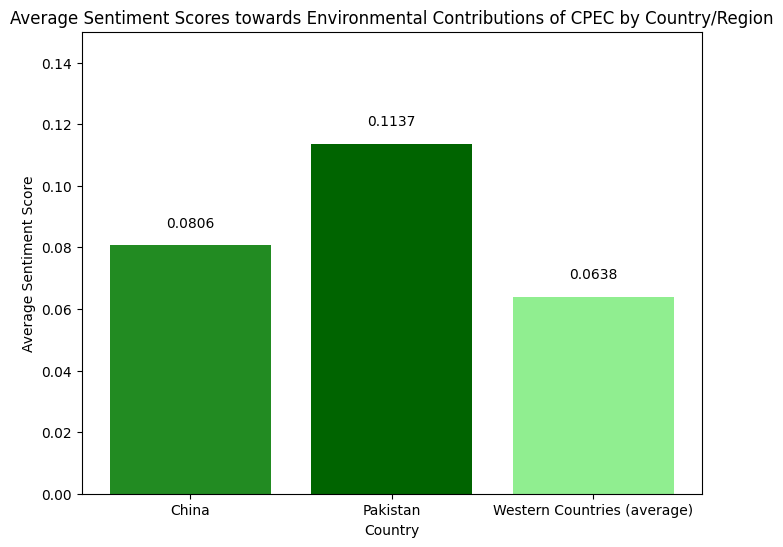

In [ ]:
import matplotlib.pyplot as plt

countries = ['China', 'Pakistan', 'Western Countries (average)']
average_sentiments = [0.08064326808835337, 0.11369900738381963, 00.06382004939222162]

plt.figure(figsize=(8, 6))
bars = plt.bar(countries, average_sentiments, color=['forestgreen', 'darkgreen', 'lightgreen'])
plt.title('Average Sentiment Scores towards Environmental Contributions of CPEC by Country/Region')
plt.xlabel('Country')
plt.ylabel('Average Sentiment Score')
plt.ylim(0, 0.15)

for bar, sentiment in zip(bars, average_sentiments):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(sentiment, 4), ha='center', va='bottom')

plt.show()
